# EDA and Feature Engineering

Dhuvi Karthikeyan

#### Importing Dependencies and Packages

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import statistics as stats
import seaborn as sns
import mhcgnomes
import difflib
import re

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Function Toolkit

In [2]:
def feature_dist(df, feature, asc=False):
    counts = dict(Counter(df[feature]))
    df = pd.DataFrame(list(counts.items()), columns = [str(feature), 'Frequency'])
    return df.sort_values(by='Frequency', ascending=asc).reset_index(drop=True)

def data_dist_vis(dataset_name, feature_df):
    '''Plot the categorical feature on a bar chart'''
    if len(feature_df) > 8:
    #Rotate the axis labels so its vertical to make space
        roto = 90
    else:
    #Rotate axis labels so its slanted to look pretty
        roto = 45 
    plt.bar(range(len(feature_df)), feature_df['Frequency'], align='center')
    plt.title(dataset_name + ' ' + feature_df.columns[0] + " Distribution")
    plt.xlabel(feature_df.columns[0])
    plt.ylabel("Frequency")
    plt.xticks(range(len(feature_df)), feature_df.iloc[:, 0], rotation = roto)
    plt.figure(figsize=(12, 8))
    plt.show()

def sparsity_viz(df):
    '''Return a heatmap represenation of the underlying dataframe that shows NAs '''
    sparsity_df = ~pd.isna(df) #returns true false table of dimensions of df
    sparsity_df = sparsity_df.applymap(int) #needs to be separated from the above for some reason
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.heatmap(sparsity_df) #returns heatmap of complete vs incomplete data

### 1. Loading the Data

The data we decided to look at will be the IEDB dataset which is filtered on multimer only data. The reason being is that the multimer stain has a high level of confidence that a specific TCR was immunologically triggered and not by bystander activation. The goal is to use test model performance on a high quality dataset before moving on to noisier data sources.

In [3]:
iedb_multimer_raw = pd.read_csv('Data/IEDB_Tcell_binding_multimer_assay.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (14,27,35,36,46,47,48,52,53,54,55,56,57,61,62,63,64,65,88,98,99,100,109) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
for i in iedb_multimer_raw.columns:
    print(i)

T Cell ID
Reference ID
Type
PubMed ID
Authors
Journal
Date
Title
Submission ID
Epitope ID
Object Type
Description
Starting Position
Ending Position
Non-peptidic epitope ChEBI ID
Antigen Name
Parent Protein
Parent Protein Accession
Organism Name
Parent Species
Parent Species ID
Epitope Comments
Epitope Relationship
Object Type.1
Description.1
Starting Position.1
Ending Position.1
Non-peptidic object Accession
Synonyms
Antigen Name.1
Parent Protein.1
Organism Name.1
Parent Organism
Name
Host ID
Geolocation
MHC Types Present
Process Type
Disease State
Disease Stage
Immunogen Epitope Relation
Immunogen Object Type
Immunogen Description
Immunogen Starting Position
Immunogen Ending Position
Non-peptidic Immunogen ChEBI ID
Immunogen Source Molecule Name
Immunogen protein parent Name
Immunogen protein parent Accession
Immunogen Organism Name
Immunogen Organism Species
Immunogen Organism Species Accession
Process Type.1
Disease State.1
Disease Stage.1
Immunogen Epitope Relation.1
Immunogen Obje

#### 1.1 Filtering for Relevant Columns

In [5]:
features_to_keep = ["T Cell ID", "Reference ID", "Epitope ID", "Description", "Antigen Name", "Parent Protein", 
                   "Organism Name", "Parent Species", "Disease State", "MHC Types Present", "Immunization Comments", "Method/Technique",
                   "Assay Group", "Qualitative Measure", "Units", "Quantitative measurement", "Number of Subjects Tested",
                    "Number of Subjects Responded", "Response Frequency", "Allele Name", "Allele Evidence Code",
                    "Assay Comments","PubMed ID", "Location of assay data in the manuscript"
                   ]

In [6]:
iedb_mmer_filtered = iedb_multimer_raw[features_to_keep]

#### 1.2 Visualizing Data Sparsity

In [7]:
#Count Complete Cases
iedb_mmer_filtered.count()/len(iedb_mmer_filtered)

T Cell ID                                   1.000000
Reference ID                                1.000000
Epitope ID                                  1.000000
Description                                 1.000000
Antigen Name                                0.823648
Parent Protein                              0.806878
Organism Name                               0.823648
Parent Species                              0.823648
Disease State                               0.743399
MHC Types Present                           0.033417
Immunization Comments                       0.560339
Method/Technique                            1.000000
Assay Group                                 1.000000
Qualitative Measure                         1.000000
Units                                       0.122264
Quantitative measurement                    0.127447
Number of Subjects Tested                   0.381670
Number of Subjects Responded                0.379169
Response Frequency                          0.

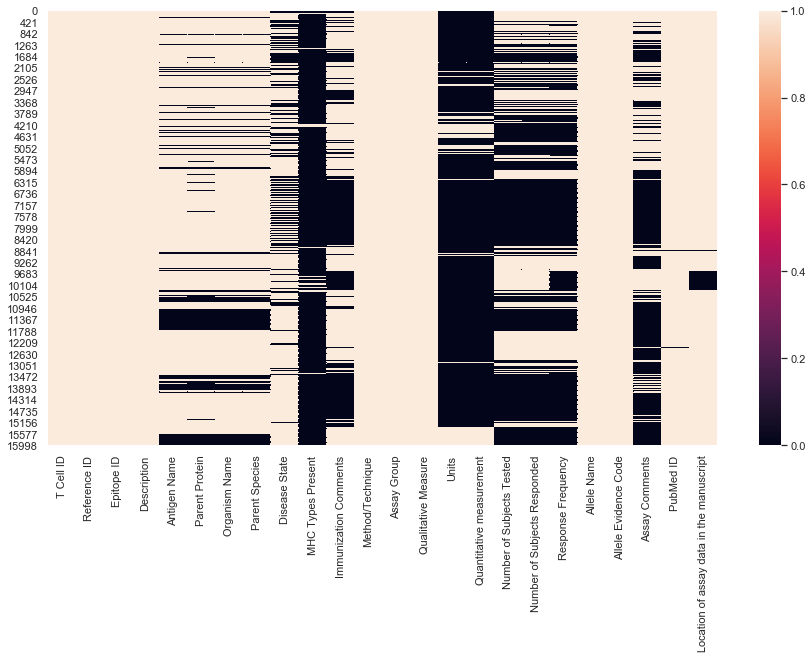

In [11]:
sparsity_viz(iedb_mmer_filtered)

#### 1.3 Visualizing Class Balance of Epitope Species Sources

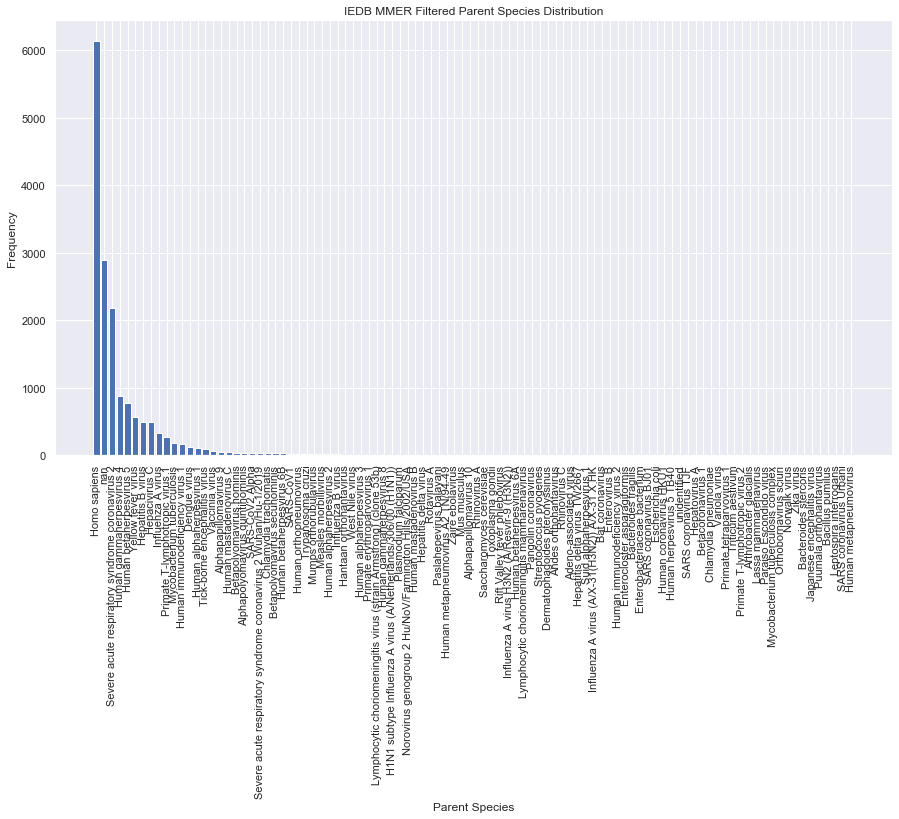

<Figure size 864x576 with 0 Axes>

In [12]:
data_dist_vis("IEDB MMER Filtered",feature_dist(iedb_mmer_filtered, 'Parent Species'))

As we can see there are a severe class imbalance problem with the available multimer epitopes in the IEDB with a majority of peptides coming from Human. The question as to whether a majority of epitopes will in fact be autoimmune must be investigated before moving forward.

In [13]:
Counter(iedb_mmer_filtered["Disease State"])

Counter({nan: 4208,
         'hepatitis D': 9,
         'cancer': 8,
         'severe acute respiratory syndrome': 9,
         'carcinoma': 1,
         'healthy': 3572,
         'multiple myeloma': 1,
         'skin melanoma': 452,
         'hepatitis C': 406,
         'viral infectious disease': 239,
         'hepatitis B': 455,
         'dengue hemorrhagic fever': 14,
         'tuberculosis': 173,
         'respiratory syncytial virus infectious disease': 4,
         'human immunodeficiency virus infectious disease': 864,
         'rheumatoid arthritis': 23,
         'bacterial infectious disease': 27,
         'asymptomatic HIV infection': 8,
         'lung adenocarcinoma': 6,
         'infectious mononucleosis': 23,
         'extrapulmonary tuberculosis': 1,
         'dengue disease': 85,
         'rheumatic fever': 2,
         'Chagas disease': 20,
         'genital herpes': 8,
         'herpes simplex': 39,
         'measles': 3,
         'non-Hodgkin lymphoma': 9,
         'huma

Due to greater than 50% of epitopes not stating which disease group they belong to we must further explore the different origins of the peptides to ensure that autoimmune peptides are not classified as immunogenic because we would like for them to be characterized as nonimmunogenic (tolerized). Perhaps a third category needs to be included.

#### 1.4 Visualizing Class Imbalance Across MHC Alleles

##### 1.4.1 Removing Serotype and Other Non-Allelic Entries

In [14]:
gnomes = [type(mhcgnomes.parse(i)) for i in iedb_mmer_filtered['Allele Name']]
Counter(gnomes)

Counter({mhcgnomes.allele.Allele: 14323,
         mhcgnomes.serotype.Serotype: 1389,
         mhcgnomes.mhc_class.MhcClass: 687})

In [15]:
allele_indices = [i for i, x in enumerate(gnomes) if x == mhcgnomes.allele.Allele] #get indices of alleles
iedb_mmer_filtered = iedb_mmer_filtered.iloc[allele_indices].reset_index(drop=True) #generate list from allele_indices
len(iedb_mmer_filtered)

14323

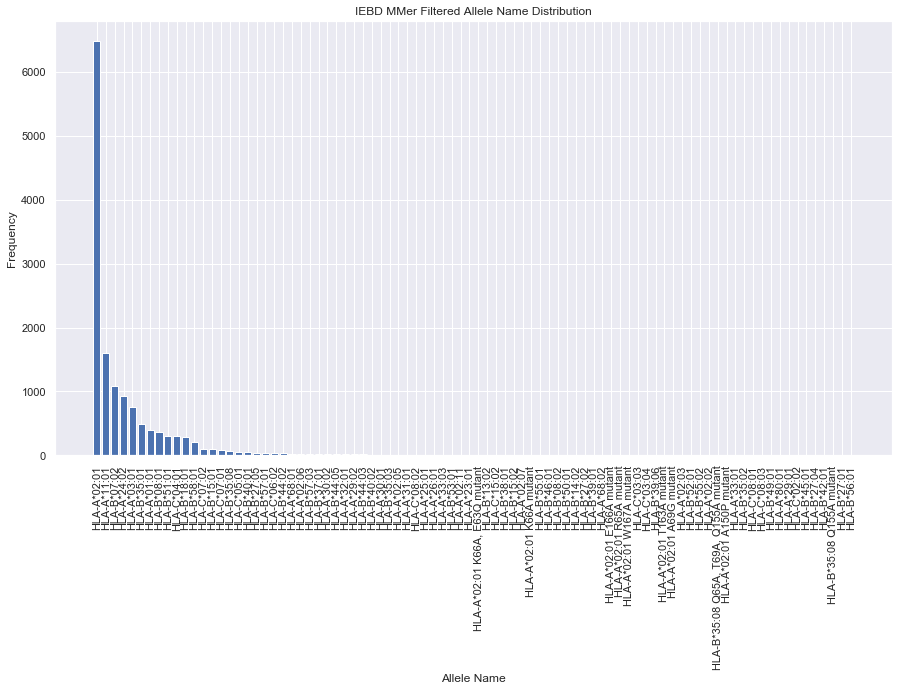

<Figure size 864x576 with 0 Axes>

In [16]:
data_dist_vis("IEBD MMer Filtered", feature_dist(iedb_mmer_filtered, "Allele Name"))

As expected there is a significant bias towards HLA-A*02:01 

#### 1.5 Immunogenicity Across Different Epitopes

In [17]:
#There are different immunogenicity readings for different epitopes
epitopes = feature_dist(iedb_mmer_filtered, "Description")
#Look at the epitopes that show up more than 10 times and return their immunogenicity values
for i in epitopes[epitopes['Frequency'] > 10]['Description']:
    print(i, feature_dist(iedb_mmer_filtered[iedb_mmer_filtered["Description"]==i], "Qualitative Measure"))

NLVPMVATV      Qualitative Measure  Frequency
0               Positive        236
1           Positive-Low          8
2               Negative          3
3          Positive-High          2
4  Positive-Intermediate          1
LLFGYPVYV      Qualitative Measure  Frequency
0               Positive        181
1          Positive-High          4
2  Positive-Intermediate          4
3               Negative          3
4           Positive-Low          2
GILGFVFTL   Qualitative Measure  Frequency
0            Positive        158
1            Negative         10
2        Positive-Low          4
3       Positive-High          3
ELAGIGILTV      Qualitative Measure  Frequency
0               Positive        143
1           Positive-Low          7
2          Positive-High          5
3  Positive-Intermediate          4
4               Negative          2
SLLMWITQC      Qualitative Measure  Frequency
0               Positive        125
1          Positive-High          9
2  Positive-Intermediate    

EPLPQGQLTAY   Qualitative Measure  Frequency
0            Positive          8
1            Negative          2
2       Positive-High          2
AVFDRKSDAK   Qualitative Measure  Frequency
0            Positive         11
1            Negative          1
HSKKKCDEL   Qualitative Measure  Frequency
0            Positive         11
1        Positive-Low          1
HMTEVVRHC   Qualitative Measure  Frequency
0            Positive          9
1        Positive-Low          2
RPHERNGFTVL   Qualitative Measure  Frequency
0            Positive         10
1       Positive-High          1
VLNDILSRL   Qualitative Measure  Frequency
0            Negative          5
1        Positive-Low          3
2            Positive          3
VMNILLQYV   Qualitative Measure  Frequency
0            Positive          9
1            Negative          1
2        Positive-Low          1
WLSLLVPFV   Qualitative Measure  Frequency
0            Positive          8
1            Negative          2
2        Positive-Low   

In [18]:
#Selected Peptide from the Above with Ambiguous Pos/Neg to see if MHC may be the reason
feature_dist(iedb_mmer_filtered[iedb_mmer_filtered["Description"]=="RLNEVAKNL"], "Allele Name")

,Allele Name,Frequency
0,HLA-A*02:01,13


In [19]:
#Selected Peptide from the Above with Ambiguous Pos/Neg to see if MHC may be the reason
feature_dist(iedb_mmer_filtered[iedb_mmer_filtered["Description"]=="LLFNILGGWV"], "Allele Name")

,Allele Name,Frequency
0,HLA-A*02:01,5


In [20]:
#Selected Peptide from the Above with Ambiguous Pos/Neg to see if MHC may be the reason
feature_dist(iedb_mmer_filtered[iedb_mmer_filtered["Description"]=="VLNDILSRL"], "Allele Name")

,Allele Name,Frequency
0,HLA-A*02:01,10
1,HLA-A*11:01,1


In [21]:
#Specifically chosen example that illustrates the variability in the reported immunogenicity
iedb_mmer_filtered[iedb_mmer_filtered["Description"]=="VLNDILSRL"]

,T Cell ID,Reference ID,Epitope ID,Description,Antigen Name,Parent Protein,Organism Name,Parent Species,Disease State,MHC Types Present,...,Units,Quantitative measurement,Number of Subjects Tested,Number of Subjects Responded,Response Frequency,Allele Name,Allele Evidence Code,Assay Comments,PubMed ID,Location of assay data in the manuscript
8508,12156757,1037393,69657,VLNDILSRL,spike glycoprotein precursor [SARS coronavirus...,NaN,SARS-CoV1,SARS-CoV1,COVID-19,NaN,...,NaN,NaN,NaN,NaN,NaN,HLA-A*02:01,Cited reference,NaN,32887977.0,Table S3
9767,12481798,1037882,69657,VLNDILSRL,surface glycoprotein [Severe acute respiratory...,Spike glycoprotein,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome coronavirus 2,COVID-19,NaN,...,NaN,NaN,17.0,1.0,5.9,HLA-A*02:01,Cited reference,Individual TCR repertoires were determined for...,33326767.0,"Figures 2, 3 and 4"
9779,12481815,1037882,69657,VLNDILSRL,surface glycoprotein [Severe acute respiratory...,Spike glycoprotein,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome coronavirus 2,healthy,NaN,...,NaN,NaN,17.0,0.0,0.0,HLA-A*02:01,Cited reference,NaN,33326767.0,Figure 2
9925,12491511,1037940,69657,VLNDILSRL,surface glycoprotein [Severe acute respiratory...,Spike glycoprotein,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome coronavirus 2,COVID-19,NaN,...,NaN,NaN,16.0,0.0,0.0,HLA-A*02:01,Single allele present,NaN,33427749.0,"Figure 2, Supplementary Figure 2 and Supplemen..."
10302,12492314,1037940,69657,VLNDILSRL,surface glycoprotein [Severe acute respiratory...,Spike glycoprotein,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome coronavirus 2,COVID-19,NaN,...,NaN,NaN,8.0,0.0,0.0,HLA-A*11:01,Single allele present,NaN,33427749.0,"Figure 2, Supplementary Figure 2 and Supplemen..."
10377,12492948,1037942,69657,VLNDILSRL,Spike glycoprotein,Spike glycoprotein,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome coronavirus 2,COVID-19,NaN,...,NaN,NaN,106.0,3.0,2.8,HLA-A*02:01,Cited reference,NaN,34098342.0,Figure 5
10430,12493208,1037960,69657,VLNDILSRL,surface glycoprotein [Severe acute respiratory...,Spike glycoprotein,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome coronavirus 2,COVID-19,NaN,...,NaN,NaN,8.0,1.0,12.5,HLA-A*02:01,Single allele present,NaN,33853928.0,Table S4 and Figure 2
11243,13846722,1037968,69657,VLNDILSRL,surface glycoprotein [Severe acute respiratory...,Spike glycoprotein,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome coronavirus 2,COVID-19,NaN,...,NaN,NaN,NaN,NaN,NaN,HLA-A*02:01,MHC binding assay,NaN,33911008.0,Figure 3
11244,13846723,1037968,69657,VLNDILSRL,surface glycoprotein [Severe acute respiratory...,Spike glycoprotein,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome coronavirus 2,healthy,NaN,...,NaN,NaN,NaN,NaN,NaN,HLA-A*02:01,MHC binding assay,NaN,33911008.0,Figure 3
11288,13913719,1037949,69657,VLNDILSRL,Spike glycoprotein,Spike glycoprotein,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome coronavirus 2,COVID-19,NaN,...,NaN,NaN,NaN,NaN,NaN,HLA-A*02:01,MHC binding prediction,NaN,32979941.0,Table S2


Since immmunogenicity is on a continuum, with the IEDB reporting weakly positive and strongly positive, we need a method to qualify the immunogenicity scores s.t. we have a calibrated ranking of immunogenicity. To this regard, we will as a naive approach take the response frequency of these peptides where available and use simple imputation schemes along with additive smoothing to better parameterize the uncertainty around true immunogenicity.

### 2. Data Imputation

In [22]:
#Assumes that there was only one individual in the sample tested
iedb_mmer_imputed = iedb_mmer_filtered

#Filters for NA and then Negative to Add 0 to Number of Responders
iedb_mmer_imputed.loc[(iedb_mmer_imputed['Number of Subjects Tested'].isna())&(iedb_mmer_imputed['Qualitative Measure'] == 'Negative'), "Number of Subjects Responded"] = 0

#Filters for NA and then Non-Negative to Add 1 to Number of Responders
iedb_mmer_imputed.loc[(iedb_mmer_imputed['Number of Subjects Tested'].isna())&(iedb_mmer_imputed['Qualitative Measure'] != 'Negative'), "Number of Subjects Responded"] = 1

#Fill in after using NAs to find where to fill in 
iedb_mmer_imputed['Number of Subjects Tested'].fillna(1, inplace = True)

###Retroactive step there are instances where subjects tested exists but not responders
## Treat these as the same as when you don't know number of tested
iedb_mmer_imputed.loc[(iedb_mmer_imputed['Number of Subjects Responded'].isna()), "Number of Subjects Tested"] = 1
iedb_mmer_imputed['Number of Subjects Responded'].fillna(1, inplace = True)

iedb_mmer_imputed['Response Frequency'] = iedb_mmer_imputed['Number of Subjects Responded']/iedb_mmer_imputed['Number of Subjects Tested']

**Note**: For many of the entries, and especially in the imputed cases, there is a certain amount of uncertainty given the low numbers of patients sampled. Furthermore there likely no peptide mhc combination that is 100% immunogenic, nor is there one that is truly 0% immunogenic. Thus we will introduce Laplace smoothing to better characterize the uncertainty around 100% or 0% response rates.

$$\hat{\theta}_{Responders} = \frac{N_{Responders} + \alpha}{(N_{Responders} + \alpha) + (N_{Nonresponders} + \alpha)} = \frac{N_{Responders} + \alpha}{N + 2\alpha}$$ 



Common choices of $\alpha$ are [0.5, 1, and 2]. Sometimes, it is recommended that $\alpha$ remains under 1. We use $\alpha = 1$ in the absense of any strong priors.  

In [23]:
iedb_mmer_imputed['Smoothed Responding Frequency'] = (iedb_mmer_imputed['Number of Subjects Responded'] + 1)/(iedb_mmer_imputed['Number of Subjects Tested'] + 2)

### 3. Combining Experiments

One of the possible sensitivities points of the analysis will be how heavily to weight number of individuals tested whithin each experiment along with the number of experiments ran. We can for example treat the various individuals across experiments as independent and then sum all the number of subjects_responed/subjects_tested. This is because there are experimental confounders such as the assay used which could affect the outcome. Take for example the following peptide:MHC filtering:

In [24]:
ex = iedb_mmer_imputed[(iedb_mmer_imputed["Description"]=="AANFCALILA") & (iedb_mmer_imputed["Allele Name"]=="HLA-A*02:01")]
ex

,T Cell ID,Reference ID,Epitope ID,Description,Antigen Name,Parent Protein,Organism Name,Parent Species,Disease State,MHC Types Present,...,Quantitative measurement,Number of Subjects Tested,Number of Subjects Responded,Response Frequency,Allele Name,Allele Evidence Code,Assay Comments,PubMed ID,Location of assay data in the manuscript,Smoothed Responding Frequency
14140,18057389,1040223,1874476,AANFCALILA,orf1ab polyprotein [Severe acute respiratory s...,Replicase polyprotein 1ab,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...,healthy,NaN,...,NaN,1.0,0.0,0.0,HLA-A*02:01,MHC binding assay,NaN,35194575.0,"Figures 2, 4, and 5",0.333333
14146,18057395,1040223,1874476,AANFCALILA,orf1ab polyprotein [Severe acute respiratory s...,Replicase polyprotein 1ab,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...,healthy,NaN,...,NaN,1.0,1.0,1.0,HLA-A*02:01,MHC binding assay,NaN,35194575.0,Figure 2,0.666667
14152,18057401,1040223,1874476,AANFCALILA,orf1ab polyprotein [Severe acute respiratory s...,Replicase polyprotein 1ab,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...,healthy,NaN,...,NaN,3.0,0.0,0.0,HLA-A*02:01,MHC binding assay,CD8+ T cells stimulated with the Wuhan peptide...,35194575.0,Figure 2,0.200000
14153,18057402,1040223,1874476,AANFCALILA,orf1ab polyprotein [Severe acute respiratory s...,Replicase polyprotein 1ab,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...,healthy,NaN,...,NaN,3.0,3.0,1.0,HLA-A*02:01,MHC binding assay,CD8+ T cells stimulated with the B.1.1.7 pepti...,35194575.0,Figure 2,0.800000
14164,18057413,1040223,1874476,AANFCALILA,orf1ab polyprotein [Severe acute respiratory s...,Replicase polyprotein 1ab,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...,COVID-19,NaN,...,NaN,4.0,4.0,1.0,HLA-A*02:01,MHC binding assay,NaN,35194575.0,Figure 4,0.833333
14170,18057419,1040223,1874476,AANFCALILA,orf1ab polyprotein [Severe acute respiratory s...,Replicase polyprotein 1ab,Severe acute respiratory syndrome coronavirus ...,Severe acute respiratory syndrome coronavirus ...,healthy,NaN,...,NaN,17.0,17.0,1.0,HLA-A*02:01,MHC binding assay,NaN,35194575.0,Figure 5,0.947368


There are a number of options of how to handle the variability among the results we get from experiments. We can treat them as independent, draw a sample of outcomes with sampling probabilities equal to the empirical distribution (one step bootstrapping), bootstrap, calculate the mode of the outcomes, or even take the geometric average. For a first pass approach, we'll take a modified geometric mean that is weighted by the number of individuals tested (personal choice that behaved well with the example above and when class switched).

In [32]:
peptides = np.unique(iedb_mmer_imputed['Description']) #listing the unique peptides
processed_peptides = [] #Epitope
processed_alleles = [] #Allele
processed_targets = [] #Frequency of Response Aggregated Across Experiments
total_tested = [] #Total Number of Subjects Tested Across Experiments
total_responded = [] #Total Number of Subjects Responded Across Experiments
response_variance = [] #Variance of Frequencies Across Experiments
n_experiments = []#Number of experiments

for i in range(len(peptides)): #iterating over peptides
    pep_filtered = iedb_mmer_imputed[iedb_mmer_imputed["Description"]==peptides[i]] #subsetting on peptide
    alleles = np.unique(pep_filtered['Allele Name'])
    for j in range(len(alleles)): #iterating over alleles
        pmhc_trials = pep_filtered[pep_filtered["Allele Name"]==alleles[j]] #filtering on Pep|Allele
        n_tot = np.sum(pmhc_trials['Number of Subjects Tested'])
        #Modified geom avg takes smoothed prob to the n_individuals power then multiplies across exp, and takes n_indiv^th root
        agg_prob = np.prod(pmhc_trials['Smoothed Responding Frequency']**pmhc_trials['Number of Subjects Tested'])**(1/n_tot)
        processed_peptides += [peptides[i]]
        processed_alleles += [alleles[j]] 
        processed_targets += [agg_prob]
        total_tested += [n_tot]
        total_responded += [np.sum(pmhc_trials['Number of Subjects Responded'])]
        response_variance += [np.var(pmhc_trials['Response Frequency'])]
        n_experiments += [len(pmhc_trials)]
examples = pd.DataFrame({'Epitope':processed_peptides,
                        'Allele Name': processed_alleles,
                        'y': processed_targets,
                        'Total Tested':total_tested,
                        'Total Responded':total_responded,
                        'Response Variance':response_variance,
                        'N_Experiments':n_experiments})
len(examples)

7109

In [26]:
#SLFGQRIEV is the highest scoring the aggregated probability. Even though there are 40 individuals, 
#there is uncertainty because they are all one experiment

iedb_mmer_imputed[iedb_mmer_imputed['Description']=='SLFGQRIEV']

,T Cell ID,Reference ID,Epitope ID,Description,Antigen Name,Parent Protein,Organism Name,Parent Species,Disease State,MHC Types Present,...,Quantitative measurement,Number of Subjects Tested,Number of Subjects Responded,Response Frequency,Allele Name,Allele Evidence Code,Assay Comments,PubMed ID,Location of assay data in the manuscript,Smoothed Responding Frequency
1189,1967240,1025413,59089,SLFGQRIEV,nonstructural protein 4B,Genome polyprotein,West Nile virus,West Nile virus,West Nile fever,NaN,...,NaN,40.0,40.0,1.0,HLA-A*02:01,Cited reference,Epitope-specific multimer positive CD8+ T cell...,21179445.0,"Figures 1-5, Suppl figure S1",0.97619


### 4. Feature Embedding

#### 4.1 HLA Sequence Mapping

In [27]:
hla_seq_table = pd.read_csv('Data/2field_HLA_consensus_sequences.csv')

In [28]:
hla_seq_dict = dict([('HLA-'+hla_seq_table['Allele'][i],hla_seq_table['Full Sequence'][i]) for i in range(len(hla_seq_table))])

In [29]:
def hla_consensus_seqmap(hla_allele, hla_dict):
    '''Map 2-Field Allele Name to Full Consensus Sequence'''
    q_allele = mhcgnomes.parse(hla_allele)
    #Take the Base Allele
    base_allele = str.split(q_allele.to_string().replace(',', ''), ' ')[0]
    #Get the allele sequence
    seq = hla_seq_dict[base_allele]
    
    if len(q_allele.mutations) > 0:
        for mut in q_allele.mutations:
            locus = mut.pos + 24 - 1 #Accounting for signal peptide and 0 index
            assert seq[locus] == mut.aa_original #Check that they match
            seq = seq[:locus] + mut.aa_mutant + seq[locus+1:] #Make the Mutation
    
    return seq



In [34]:
examples['Allele Sequence'] = [hla_consensus_seqmap(allele, hla_seq_dict) for allele in examples['Allele Name']]
examples

,Epitope,Allele Name,y,Total Tested,Total Responded,Response Variance,N_Experiments,Allele Sequence
0,AAAACTTMK,HLA-A*03:01,0.636364,9.0,6.0,0.000000,1,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...
1,AAAGFLFCV,HLA-A*02:01,0.375000,6.0,2.0,0.000000,1,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...
2,AAAPTPSPV,HLA-B*07:02,0.333333,2.0,0.0,0.000000,2,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...
3,AACFARSR,HLA-A*11:01,0.036480,45.0,0.0,0.000000,2,MAVMAPRTLLLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...
4,AADHRQLQL,HLA-C*05:01,0.250000,2.0,0.0,0.000000,1,MRVMAPRTLILLLSGALALTETWACSHSMRYFYTAVSRPGRGEPRF...
...,...,...,...,...,...,...,...,...
7104,YYTSNPTTFHL,HLA-A*24:02,0.285714,5.0,1.0,0.000000,1,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFSTSVSRPGRGEPRF...
7105,YYTVRNFTL,HLA-A*24:02,0.470702,8.0,4.0,0.068889,3,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFSTSVSRPGRGEPRF...
7106,YYVGYLQPRTF,HLA-A*24:02,0.142857,5.0,0.0,0.000000,1,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFSTSVSRPGRGEPRF...
7107,YYYRFVIGL,HLA-C*07:02,0.200000,3.0,0.0,0.000000,1,MRVMAPRALLLLLSGGLALTETWACSHSMRYFDTAVSRPGRGEPRF...


The HIV nucleoside analog reverse transcriptase inhibitor (NRTI) abacavir somehow made it into the epitopes list so we will manually remove it along with other non amino acid epitopes.

##### Epitope Cleanign?

In [35]:
final_df = examples[~examples.Epitope.str.contains('[^A-Z]')]

In [ ]:
final_df